##Importing modules and mounting drive

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import random
import os
import re
import tensorflow as tf
from tensorflow.keras import layers,models
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, LeaveOneOut, KFold
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from scikeras.wrappers import KerasClassifier

## Image Generation

In [ ]:
# Define the range for PERSON and POSTURE
postures = {'B': 10, 'C': 3, 'D': 3, 'E': 6, 'F': 7}
cat = {'Air_Mat': 'Matrix_Air', 'Sponge_Mat': 'Matrix_Sponge'}
for post in postures:
    for PERSON in range(1, 9):
        for POSTURE in range(1, (postures[post]) + 1):
            for category in cat:
                # Define directory
                directory = f"/content/drive/Shareddrives/Project Sleep/PMD/experiment-ii/S{PERSON}/{category}"

                # Select the file for which you want to generate the video
                selected_file = f"{cat[category]}_{post}{POSTURE}.txt"  # Change to the desired filename

                # Read the selected file
                file_path = os.path.join(directory, selected_file)
                try:
                    df = pd.read_csv(file_path, sep=' ', header=None)
                    # Ensure the dataframe has the correct dimensions
                    if df.shape == (64, 27):
                        frame_image = df.values

                        # Define the image path
                        image_path = f"/content/drive/Shareddrives/Project Sleep/Image2/{category}_S{PERSON}_{post}{POSTURE}.png"  # Change the path as needed

                        # Create the heatmap image
                        plt.figure(figsize=(4, 6))
                        sns.heatmap(frame_image, vmin=0, vmax=1000, cmap='magma', annot=False, xticklabels=False, yticklabels=False, cbar=False)
                        plt.axis('off')  # Turn off axis
                        plt.savefig(image_path, bbox_inches='tight', pad_inches=0)  # Save without extra whitespace
                        plt.close()
                    else:
                        print(f"Invalid dimensions for file: {file_path}")
                except FileNotFoundError:
                    print(f"File not found: {file_path}")


File not found: /content/drive/Shareddrives/Project Sleep/PMD/experiment-ii/S7/Air_Mat/Matrix_Air_B8.txt
File not found: /content/drive/Shareddrives/Project Sleep/PMD/experiment-ii/S7/Air_Mat/Matrix_Air_F1.txt


##Generating Labels for every image

In [ ]:
image_directory = "/content/drive/Shareddrives/Project Sleep/Image2"
posture_names={"B":"Supine","C":"Right","D":"Left","F":"Supine","E1":"Right","E2":"Right","E5":"Right","E3":"Left","E4":"Left","E6":"Left"}
labels={}
for filename in os.listdir(image_directory):
  if "B" in filename:
    labels[filename]=posture_names["B"]
  elif "C" in filename:
    labels[filename]=posture_names["C"]
  elif "D" in filename:
    labels[filename]=posture_names["D"]
  elif "F" in filename:
    labels[filename]=posture_names["F"]
  elif "E1" in filename or "E2" in filename or "E5" in filename:
    labels[filename]=posture_names["E1"]
  elif "E3" in filename or "E4" in filename or "E6" in filename:
    labels[filename]=posture_names["E3"]

labels

{'Air_Mat_S1_B1.png': 'Supine',
 'Sponge_Mat_S1_B1.png': 'Supine',
 'Sponge_Mat_S1_B2.png': 'Supine',
 'Air_Mat_S1_B2.png': 'Supine',
 'Air_Mat_S1_B3.png': 'Supine',
 'Sponge_Mat_S1_B3.png': 'Supine',
 'Air_Mat_S1_B4.png': 'Supine',
 'Sponge_Mat_S1_B4.png': 'Supine',
 'Air_Mat_S1_B5.png': 'Supine',
 'Sponge_Mat_S1_B5.png': 'Supine',
 'Air_Mat_S1_B6.png': 'Supine',
 'Sponge_Mat_S1_B6.png': 'Supine',
 'Sponge_Mat_S1_B7.png': 'Supine',
 'Air_Mat_S1_B7.png': 'Supine',
 'Air_Mat_S1_B8.png': 'Supine',
 'Sponge_Mat_S1_B8.png': 'Supine',
 'Air_Mat_S1_B9.png': 'Supine',
 'Sponge_Mat_S1_B9.png': 'Supine',
 'Air_Mat_S1_B10.png': 'Supine',
 'Sponge_Mat_S1_B10.png': 'Supine',
 'Air_Mat_S2_B1.png': 'Supine',
 'Sponge_Mat_S2_B1.png': 'Supine',
 'Sponge_Mat_S2_B2.png': 'Supine',
 'Air_Mat_S2_B2.png': 'Supine',
 'Air_Mat_S2_B3.png': 'Supine',
 'Air_Mat_S2_B4.png': 'Supine',
 'Sponge_Mat_S2_B3.png': 'Supine',
 'Sponge_Mat_S2_B4.png': 'Supine',
 'Air_Mat_S2_B5.png': 'Supine',
 'Sponge_Mat_S2_B6.png': 'Su

##Model Building

In [ ]:
image_directory = "/content/drive/Shareddrives/Project Sleep/Image2"

image_paths = [os.path.join(image_directory, filename) for filename in labels.keys()]
posture_labels = list(labels.values())

images = []
for img_path in image_paths:
    img = load_img(img_path, target_size=(32, 64))  # Resize the images to a common size
    img_array = img_to_array(img) / 255.0
    images.append(img_array)
images

[array([[[0.02352941, 0.01960784, 0.09411765],
         [0.02352941, 0.01960784, 0.09411765],
         [0.01960784, 0.01568628, 0.08627451],
         ...,
         [0.02352941, 0.01960784, 0.09411765],
         [0.01960784, 0.01568628, 0.08627451],
         [0.01960784, 0.01568628, 0.08627451]],
 
        [[0.02352941, 0.01960784, 0.09411765],
         [0.02352941, 0.01960784, 0.09411765],
         [0.02352941, 0.01960784, 0.09411765],
         ...,
         [0.02352941, 0.01960784, 0.09411765],
         [0.02352941, 0.01960784, 0.09411765],
         [0.02352941, 0.01960784, 0.09411765]],
 
        [[0.02352941, 0.01960784, 0.10196079],
         [0.02352941, 0.01960784, 0.10196079],
         [0.03137255, 0.02745098, 0.11764706],
         ...,
         [0.02352941, 0.01960784, 0.10196079],
         [0.02352941, 0.01960784, 0.09411765],
         [0.02352941, 0.01960784, 0.09411765]],
 
        ...,
 
        [[0.17254902, 0.06666667, 0.37254903],
         [0.17254902, 0.06666667, 0.37254

In [ ]:
X = np.array(images)
y = np.array(posture_labels)
x_train, x_val, y_train, y_val = train_test_split(X, posture_labels, test_size=0.3, random_state=42)

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 64 ,3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(3,activation='softmax')  # Output layer with softmax activation for multiclass classification
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy since the labels are not one-hot encoded
              metrics=['accuracy'])
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

y_train_encoded = label_encoder.transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_train,y_train_encoded

(['Supine',
  'Supine',
  'Supine',
  'Left',
  'Supine',
  'Supine',
  'Supine',
  'Supine',
  'Supine',
  'Left',
  'Right',
  'Supine',
  'Supine',
  'Supine',
  'Right',
  'Supine',
  'Supine',
  'Supine',
  'Left',
  'Supine',
  'Left',
  'Supine',
  'Left',
  'Supine',
  'Left',
  'Supine',
  'Supine',
  'Right',
  'Supine',
  'Supine',
  'Right',
  'Right',
  'Supine',
  'Supine',
  'Supine',
  'Right',
  'Left',
  'Supine',
  'Supine',
  'Supine',
  'Supine',
  'Supine',
  'Supine',
  'Left',
  'Right',
  'Supine',
  'Left',
  'Supine',
  'Supine',
  'Right',
  'Right',
  'Supine',
  'Left',
  'Supine',
  'Supine',
  'Left',
  'Right',
  'Supine',
  'Left',
  'Right',
  'Supine',
  'Supine',
  'Right',
  'Right',
  'Supine',
  'Left',
  'Supine',
  'Supine',
  'Supine',
  'Left',
  'Right',
  'Supine',
  'Right',
  'Right',
  'Right',
  'Right',
  'Left',
  'Right',
  'Supine',
  'Left',
  'Right',
  'Supine',
  'Supine',
  'Supine',
  'Supine',
  'Supine',
  'Supine',
  'Left'

In [ ]:
pred = model.fit(x_train, y_train_encoded, epochs=100,batch_size=20, validation_data=(x_val, y_val_encoded))


Epoch 1/100
17/17 [==============================] - 2s 44ms/step - loss: 0.8282 - accuracy: 0.6068 - val_loss: 0.5503 - val_accuracy: 0.7554
Epoch 2/100
17/17 [==============================] - 1s 35ms/step - loss: 0.6179 - accuracy: 0.7554 - val_loss: 0.4440 - val_accuracy: 0.8345
Epoch 3/100
17/17 [==============================] - 1s 34ms/step - loss: 0.4246 - accuracy: 0.8452 - val_loss: 0.3269 - val_accuracy: 0.8633
Epoch 4/100
17/17 [==============================] - 1s 34ms/step - loss: 0.3197 - accuracy: 0.8916 - val_loss: 0.4165 - val_accuracy: 0.7770
Epoch 5/100
17/17 [==============================] - 1s 34ms/step - loss: 0.2651 - accuracy: 0.8947 - val_loss: 0.2648 - val_accuracy: 0.8921
Epoch 6/100
17/17 [==============================] - 1s 35ms/step - loss: 0.2209 - accuracy: 0.9164 - val_loss: 0.2046 - val_accuracy: 0.9065
Epoch 7/100
17/17 [==============================] - 1s 35ms/step - loss: 0.1460 - accuracy: 0.9443 - val_loss: 0.1774 - val_accuracy: 0.9281
Epoch 

##Sampling Techniques- oversampling,downsampling,class-weights

In [ ]:
#Downsampling

from sklearn.utils import resample
x_train_flattened = x_train.reshape(x_train.shape[0], -1)
train_data=np.column_stack((x_train_flattened,y_train_encoded))
balanced_data = np.empty((0, train_data.shape[1]), dtype=train_data.dtype)
        # Separate majority and minority classes

majority_class = train_data[train_data[:, -1] == 2]
minority_class = train_data[train_data[:, -1] !=2]
n_samples_to_downsample = min(len(majority_class), len(minority_class))

        # Downsample majority class
majority_downsampled = resample(majority_class,
                                        replace=False,  # sample without replacement
                                        n_samples=n_samples_to_downsample,  # match minority class
                                        random_state=42)  # reproducible results
print(len(majority_downsampled),len(majority_class))
downsampled = np.concatenate([majority_downsampled, minority_class])
balanced_data = np.concatenate([balanced_data, downsampled])
np.random.shuffle(balanced_data)
x_balanced = balanced_data[:, :-1]
# Reshape flattened data back to original shape
x_balanced_reshaped = x_balanced.reshape(x_balanced.shape[0], 32, 64, 3)

y_balanced = balanced_data[:, -1]
#Downsampling
print(len(x_balanced_reshaped),len(y_balanced))
pred = model.fit(x_balanced_reshaped, y_balanced, epochs=10, validation_data=(x_val, y_val_encoded))


146 177
292 292
Epoch 1/10
10/10 [==============================] - 2s 134ms/step - loss: 0.9446 - accuracy: 0.5103 - val_loss: 0.7907 - val_accuracy: 0.6619
Epoch 2/10
10/10 [==============================] - 1s 128ms/step - loss: 0.6534 - accuracy: 0.7637 - val_loss: 0.5736 - val_accuracy: 0.7986
Epoch 3/10
10/10 [==============================] - 1s 143ms/step - loss: 0.5445 - accuracy: 0.7842 - val_loss: 0.4385 - val_accuracy: 0.7842
Epoch 4/10
10/10 [==============================] - 1s 75ms/step - loss: 0.4924 - accuracy: 0.7911 - val_loss: 0.4096 - val_accuracy: 0.8345
Epoch 5/10
10/10 [==============================] - 1s 83ms/step - loss: 0.3513 - accuracy: 0.8699 - val_loss: 0.3990 - val_accuracy: 0.8417
Epoch 6/10
10/10 [==============================] - 1s 76ms/step - loss: 0.3168 - accuracy: 0.8767 - val_loss: 0.4042 - val_accuracy: 0.8345
Epoch 7/10
10/10 [==============================] - 1s 75ms/step - loss: 0.3013 - accuracy: 0.8630 - val_loss: 0.2852 - val_accuracy: 0

In [ ]:
#Oversampling
from imblearn.over_sampling import SMOTE

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
x_train_flattened = x_train.reshape(x_train.shape[0], -1)
x_train_oversampled, y_train_oversampled = smote.fit_resample(x_train_flattened, y_train_encoded)

# Stack oversampled data
train_data_oversampled = np.column_stack((x_train_oversampled, y_train_oversampled))

# Shuffle the balanced dataset
np.random.shuffle(train_data_oversampled)

# Separate features and target
x_oversampled = train_data_oversampled[:, :-1]
x_oversampled_reshaped = x_oversampled.reshape(x_oversampled.shape[0], 32, 64, 3)
y_oversampled = train_data_oversampled[:, -1]
pred = model.fit(x_oversampled_reshaped, y_oversampled, epochs=10, validation_data=(x_val, y_val_encoded))


Epoch 1/10
17/17 [==============================] - 2s 88ms/step - loss: 0.7844 - accuracy: 0.6403 - val_loss: 1.0712 - val_accuracy: 0.6259
Epoch 2/10
17/17 [==============================] - 1s 80ms/step - loss: 0.4549 - accuracy: 0.8475 - val_loss: 0.5224 - val_accuracy: 0.7770
Epoch 3/10
17/17 [==============================] - 1s 80ms/step - loss: 0.2947 - accuracy: 0.8983 - val_loss: 0.2949 - val_accuracy: 0.8561
Epoch 4/10
17/17 [==============================] - 1s 75ms/step - loss: 0.2027 - accuracy: 0.9322 - val_loss: 0.3699 - val_accuracy: 0.8777
Epoch 5/10
17/17 [==============================] - 1s 78ms/step - loss: 0.1295 - accuracy: 0.9529 - val_loss: 0.4019 - val_accuracy: 0.8273
Epoch 6/10
17/17 [==============================] - 1s 81ms/step - loss: 0.1053 - accuracy: 0.9623 - val_loss: 0.2506 - val_accuracy: 0.8849
Epoch 7/10
17/17 [==============================] - 2s 129ms/step - loss: 0.0593 - accuracy: 0.9849 - val_loss: 0.2974 - val_accuracy: 0.9137
Epoch 8/10
1

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced',classes= np.unique(y_train_encoded), y=y_train_encoded)

# Convert class weights to a dictionary
class_weights_dict = dict(zip(np.unique(y_train_encoded), class_weights))
pred = model.fit(x_train, y_train_encoded,
                 epochs=10,
                 validation_data=(x_val, y_val_encoded),
                 class_weight=class_weights_dict)


Epoch 1/10
11/11 [==============================] - 6s 206ms/step - loss: 0.9522 - accuracy: 0.4551 - val_loss: 0.6881 - val_accuracy: 0.7698
Epoch 2/10
11/11 [==============================] - 2s 148ms/step - loss: 0.5599 - accuracy: 0.7957 - val_loss: 0.7140 - val_accuracy: 0.7194
Epoch 3/10
11/11 [==============================] - 2s 136ms/step - loss: 0.4156 - accuracy: 0.8545 - val_loss: 0.6289 - val_accuracy: 0.7410
Epoch 4/10
11/11 [==============================] - 1s 77ms/step - loss: 0.3405 - accuracy: 0.8390 - val_loss: 0.6624 - val_accuracy: 0.7554
Epoch 5/10
11/11 [==============================] - 1s 82ms/step - loss: 0.3133 - accuracy: 0.8514 - val_loss: 0.4793 - val_accuracy: 0.7842
Epoch 6/10
11/11 [==============================] - 1s 76ms/step - loss: 0.2198 - accuracy: 0.8916 - val_loss: 0.5951 - val_accuracy: 0.7770
Epoch 7/10
11/11 [==============================] - 1s 82ms/step - loss: 0.2264 - accuracy: 0.8793 - val_loss: 0.3430 - val_accuracy: 0.8489
Epoch 8/10

##Validating model and calculating metrics







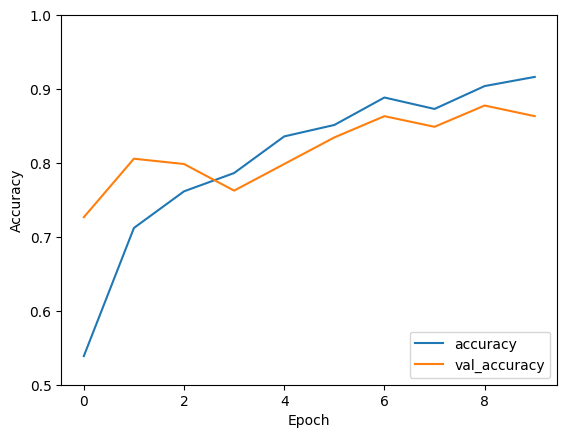

In [ ]:
plt.plot(pred.history['accuracy'], label='accuracy')
plt.plot(pred.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

In [ ]:
image_path = "/content/drive/Shareddrives/Project Sleep/Image2/Air_Mat_S7_D3.png"

def predict_class(img_array, model):
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    return predicted_class

img = load_img(image_path, target_size=(32, 64))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array/=255.0
predicted_class_index = predict_class(img_array, model)

class_names = {2: 'Supine', 0: 'Left', 1:'Right'}

predicted_class_name = class_names[predicted_class_index]
print("Predicted class:", predicted_class_name)


1/1 [==============================] - 0s 76ms/step
Predicted class: Left


In [ ]:

# Function to extract the true label from the image filename
def extract_true_label(filename):
    # Extracting the number from the filename
    return labels[filename]

# Function to predict the class of an image
def predict_class(img_array, model):
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    return predicted_class

# Path to the directory containing images
image_dir = "/content/drive/Shareddrives/Project Sleep/Image2/"

# Load the model
# Assuming you have already loaded your CNN model and stored it in a variable called 'model'

# List to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through each image file in the directory
for filename in os.listdir(image_dir):
    if filename.endswith(".png"):
        image_path = os.path.join(image_dir, filename)

        # Load and preprocess the image
        img = load_img(image_path, target_size=(32, 64))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0

        # Predict the class of the image
        predicted_class_index = predict_class(img_array, model)

        # Extract the true label from the filename
        true_label = extract_true_label(filename)

        # Store the true label and predicted label
        true_labels.append(true_label)
        predicted_labels.append(class_names[predicted_class_index])

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Calculate precision, recall, F1 score, and accuracy
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')
accuracy = accuracy_score(true_labels, predicted_labels)

# Print the metrics
print("Confusion Matrix:\n", cm)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", accuracy)

1/1 [==============================] - 0s 15ms/step
Confusion Matrix:
 [[ 93   0   3]
 [  0  94   2]
 [  5   1 264]]
Precision: 0.9763483271427322
Recall: 0.9761904761904762
F1 Score: 0.9762406485468139
Accuracy: 0.9761904761904762


##Hyperparameter Tuning

In [ ]:
pip install scikeras[tensorflow]  # cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 713.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 70.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 38.3 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.10.0
    Uninstalling typing_extensions-4.10.0:
      Successfully uninstalled typing_extensions-4.10.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
  Attempting uninstall: keras
   

In [ ]:
import os
import numpy as np
from sklearn.model_selection import KFold, LeaveOneGroupOut, GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load data and preprocess
image_directory = "/content/drive/Shareddrives/Project Sleep/Image2"
image_paths = [os.path.join(image_directory, filename) for filename in labels.keys()]
posture_labels = list(labels.values())

images = []
for img_path in image_paths:
    img = load_img(img_path, target_size=(32, 64))  # Resize the images to a common size
    img_array = img_to_array(img) / 255.0
    images.append(img_array)

X = np.array(images)
y = np.array(posture_labels)

# Split data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Define CNN model function
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 64, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')  # Output layer with softmax activation for multiclass classification
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Wrap Keras model with KerasClassifier
model = KerasClassifier(build_fn=create_model, verbose=0)

# Define hyperparameters for tuning
param_grid = {
    'batch_size': [12, 14, 20],
    'epochs': [10, 50, 100]
}

# Define cross-validation strategy (e.g., k-fold or LOSO)
kfold_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform hyperparameter tuning using GridSearchCV with k-fold cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold_cv)
grid_result = grid_search.fit(x_train, y_train)

best_params = grid_result.best_params_
best_score = grid_result.best_score_

print("Best parameters:", best_params)
print("Best score:", best_score)


<ipython-input-25-0d0317384426>:45: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


Best parameters: {'batch_size': 20, 'epochs': 100}
Best score: 0.9351923108100891
